<a href="https://colab.research.google.com/github/Allessyer/Bayesian-Optimization-in-LPA/blob/main/Task%202.%201%20parameter/Bayesian%20Optimization/exp1_bo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1MKupYy45LsOo8siSUEaceE9VccxqK7it?usp=sharing)


# Experiment 1

## 1 parameter. Vary E_laser

In [ ]:
from my_functions.bo_functions import generate_initial_data
from my_functions.bo_functions import Bayesian_Optimization
from my_functions.bo_functions import plot_convergence
import numpy as np

In [ ]:
from my_functions.objective_function import LPA_stage
from my_functions.objective_function import forrester

In [ ]:
import torch
import matplotlib.pyplot as plt
import pandas as pd

### Download Initial dataset

In [ ]:
def download_initial_data(r_min, r_max, n_points, obj_func_type, filtered = True,d=1):
    
    if filtered:
        df = pd.read_csv("../../initial_dataset/df_filtered.csv")
    else:
        df = pd.read_csv("../../initial_dataset/df_non_filtered.csv")
    
    df.drop(df[df.x > r_max].index,inplace=True)
    df.reset_index(drop=True,inplace=True)
    
    x_train = torch.Tensor(df.x.values)
    y_train = torch.Tensor(df[f'y{obj_func_type}'].values)
    x_train = x_train.unsqueeze(-1)
    y_train = y_train.unsqueeze(-1)
    bounds = torch.stack([r_min * torch.ones(d), r_max * torch.ones(d)])
    
    if n_points < x_train.shape[0]:
        return x_train[:n_points], y_train[:n_points],bounds
    else:
        return x_train,y_train,bounds

### Create initial dataset

In [ ]:
r_min, r_max = [1.,20.]  # parameters bounds
n_points = 5
n_steps = 20 # BO steps
obj_type = 2 # start with 1, not 0
filtered = True
maximize = False
objective_function = lambda varied_param: LPA_stage(varied_param,
                                                    filtered=filtered,
                                                    obj_type=obj_type) 

In [ ]:
x_train,y_train,bounds = generate_initial_data(r_min,r_max,objective_function,n_points)

Generating particle distribution... Done.

Plasma stage
------------
Tracking in 10 step(s)... [--------------------] Done (130.623 seconds).
--------------------------------------------------------------------------------
E_average = 311.74406698946046
abs difference = 161.74406698946046
Elapsed time: 2.1870739687175957 minutes
objective_function = 161.74406698946046
Generating particle distribution... Done.

Plasma stage
------------
Tracking in 10 step(s)... [--------------------] Done (114.816 seconds).
--------------------------------------------------------------------------------
E_average = 282.1980117312663
abs difference = 132.19801173126632
Elapsed time: 1.9216146652004682 minutes
objective_function = 132.19801173126632
Generating particle distribution... Done.

Plasma stage
------------
Tracking in 10 step(s)... [--------------------] Done (118.749 seconds).
--------------------------------------------------------------------------------
E_average = 263.19366805333567
abs d

### Run BO

In [ ]:
n_steps = 20
x_train,y_train = Bayesian_Optimization(r_min,r_max,x_train,y_train,bounds,objective_function=objective_function,n_steps=n_steps,maximize=maximize)

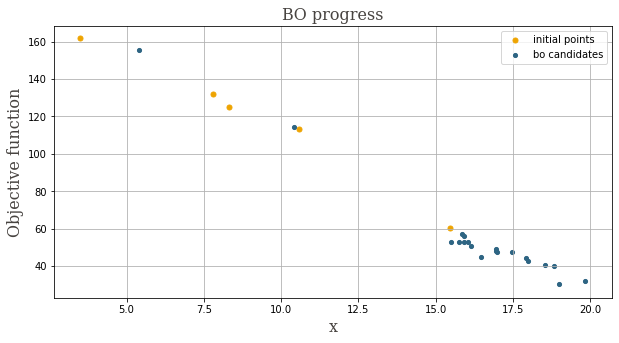

In [ ]:
font = {'family': 'serif',
        'color':  '#484441',   
        'weight': 'normal',
        'size': 16,
        }

plt.figure(figsize = (10,5))
plt.scatter(x_train[:5],y_train[:5],color='#EEA402',s=25,label = 'initial points')
plt.scatter(x_train[5:],y_train[5:],color='#2E6583',s=17,label = 'bo candidates')  #2E6583
# plt.ylim(-0.0001,0.0004)
plt.title('BO progress',fontdict=font)
plt.xlabel("x",fontdict=font)
plt.ylabel("Objective function",fontdict=font)
plt.legend()
plt.grid()

plt.savefig("bo_progress.png")

In [ ]:
print('Maximum y: ',torch.min(y_train))
print(f'Maximum x: {x_train[torch.argmin(y_train)]}')

Maximum y:  tensor(30.5671)
Maximum x: tensor([18.9774])


### Best simulation

In [ ]:
from my_functions.run_simulation import run_simulation
from my_functions.assel_functions import best_sim_obj
from my_functions.assel_functions import delete_dir
from my_functions.simulation_analysis import best_sim_analysis

In [ ]:
E_laser = 18.9774

In [ ]:
bunch, bunch_list = run_simulation(E_laser)

Generating particle distribution... Done.

Plasma stage
------------
Tracking in 10 step(s)... [--------------------] Done (102.408 seconds).
--------------------------------------------------------------------------------


In [ ]:
objective_function = best_sim_obj(E_laser,filtered=True,obj_type='all')

obj_func = [0.3765644222407465, 1.359081550117297e-05, 0.4246863223091517, 0.35173155516028026, 31.112406355875578, 1193.207153264027]


In [ ]:
from openpmd_viewer import OpenPMDTimeSeries
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
ts = OpenPMDTimeSeries(f'./diags/hdf5/', backend='h5py')

In [ ]:
from_iter = 0
till_iter = 9

Energy [MeV] 11.624109113192675
Energy [MeV] 53.58372778506608
Energy [MeV] 89.55225230549881
Energy [MeV] 111.65063175906572
Energy [MeV] 120.15348962937735
Energy [MeV] 131.51366666284173
Energy [MeV] 142.2014454936804
Energy [MeV] 154.91371775918154
Energy [MeV] 167.95777464873223
Energy [MeV] 176.3800956718311


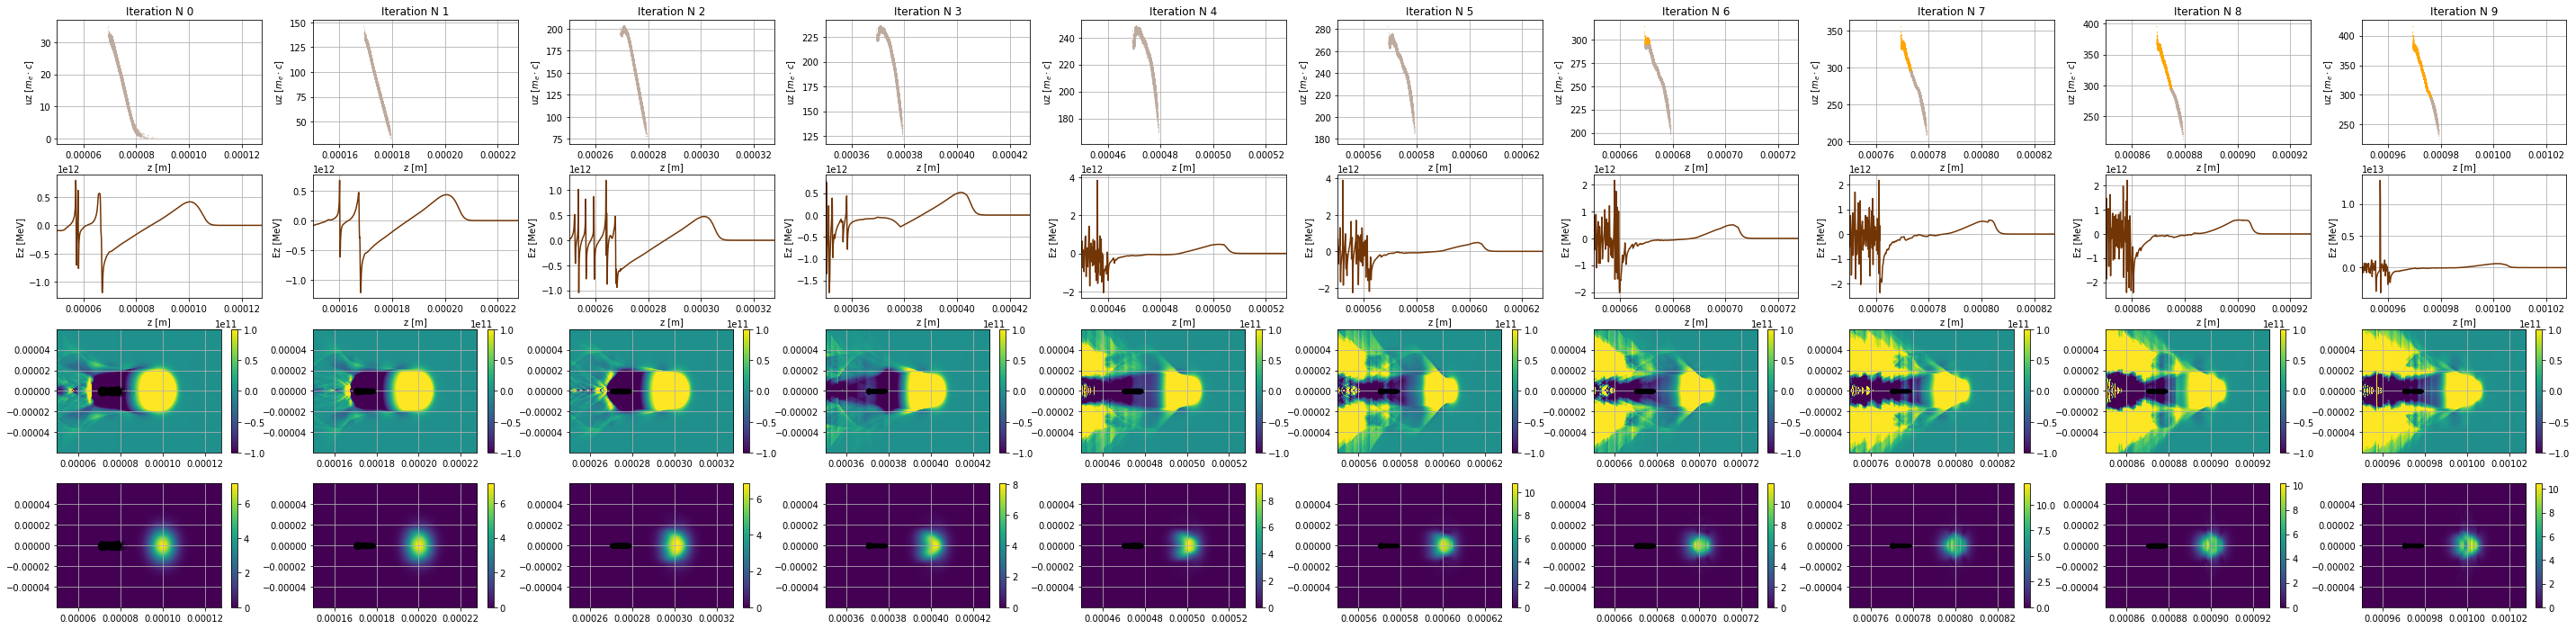

In [ ]:
rows = 4
columns = till_iter+1 - from_iter
fig = plt.figure(figsize=(5*columns, 3*rows))
grid = plt.GridSpec(rows, columns, wspace = .25, hspace = .25)
N_iterations = till_iter+1 - from_iter

Beam_energy = []

for index,iteration in enumerate(range(from_iter,till_iter+1)):
    z,uz = ts.get_particle(var_list = ['z','uz'],species='bunch',iteration=iteration)
    above150_uz = []
    above150_z = []
    below150_uz = []
    below150_z = []
    for i in range(len(uz)):
        if (uz[i]-1)*0.511 >= 150:
            above150_uz.append(uz[i])
            above150_z.append(z[i])
        else:
            below150_uz.append(uz[i])
            below150_z.append(z[i]) 
    Ez, m = ts.get_field(iteration=iteration, field='E', coord='z')

    exec (f"plt.subplot(grid{[columns * 0 + index]})")

    plt.plot(above150_z,above150_uz,'.',ms=0.5,color='orange', label = 'above 150 MeV')
    plt.plot(below150_z,below150_uz,'.',ms=0.5,color='#beab9e',label = 'below 150 MeV')
    plt.grid()
    plt.xlabel('z [m]')
    plt.ylabel('uz [$m_e \cdot c$]')
    plt.title(f"Iteration N {iteration}")
    plt.xlim([m.zmin, m.zmax])

    exec (f"plt.subplot(grid{[columns * 1 + index]})")
    plt.plot(m.z, Ez[Ez.shape[0]//2,:],color='#723505')
    plt.ylabel('Ez [MeV]')
    plt.xlabel('z [m]')
    plt.xlim([m.zmin, m.zmax])
    plt.grid()


    x, z, ux, uz = ts.get_particle(iteration=iteration, var_list=['x', 'z', 'ux', 'uz'], species='bunch')
    print("Energy [MeV]", .511*(np.mean(uz)-1))
    Beam_energy.append(.511*(np.mean(uz)-1))

    F, m = ts.get_field(iteration=iteration, field='E', coord='z')
    L, m = ts.get_field(iteration=iteration, field='a_mod')


    exec (f"plt.subplot(grid{[columns * 2 + index]})")
    plt.imshow(F, extent=m.imshow_extent, aspect='auto')
    plt.clim(-1.e11,1.e11)
    plt.colorbar()

    plt.plot(z,x,'k.',ms=.1)
    plt.xlim([m.zmin, m.zmax])
    plt.ylim([m.rmin, m.rmax])
    plt.grid()

    exec (f"plt.subplot(grid{[columns * 3 + index]})")
    plt.imshow(L, extent=m.imshow_extent, aspect='auto')
    plt.colorbar()

    plt.plot(z,x,'k.',ms=.1)
    plt.xlim([m.zmin, m.zmax])
    plt.ylim([m.rmin, m.rmax])
    plt.grid()